# 00 Import libraries

In [1]:
import numpy as np
import json
import torch
from scipy.stats import ttest_ind, levene
import os
import seaborn as sns
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import plotting
import pandas as pd
from statsmodels.stats.multitest import fdrcorrection

# 01 load coordinates

In [2]:
data = nib.load('../data/atlas/HCPMMP1_for_ABCD.nii.gz')

In [3]:
coordinates = plotting.find_parcellation_cut_coords(labels_img=data)

In [4]:
coordinates.shape

(360, 3)

# 02 load interpretability

In [27]:
healthy_path = '../../divfreqBERT/visualization/ABCD_spatiotemporal_three_divfreqBERT_HCPMMP1_ADHD/ABCD_target0'
save_healthy_path = '../sample_visualization/ADHD/target_healthy'
os.makedirs(save_healthy_path)
sub_list = list(set([i.split('_')[0] for i in os.listdir(healthy_path)]))

In [28]:
for i, name in enumerate(sub_list[:20]):
    activation_path = healthy_path+f'/{name}_att_mat_activation.json'
    gradient_path = healthy_path+f'/{name}_att_mat_gradient.json'
    with open(activation_path, 'r') as file:
        activations = json.load(file)
    with open(gradient_path, 'r') as file:
        gradients = json.load(file)
    
    # high
    high_act = torch.tensor(activations['high_spatial_attention'])
    high_grad = torch.tensor(gradients['high_spatial_attention'])
    torch.save(high_act, save_healthy_path+f'/{name}_activation.pt')
    torch.save(high_grad, save_healthy_path+f'/{name}_gradient.pt')

In [29]:
high_contribution = np.zeros((len(sub_list[:20]), 180, 180))

for i, name in enumerate(sub_list[:20]):
    high_act = torch.load(save_healthy_path+f'/{name}_activation.pt')
    high_grad = torch.load(save_healthy_path+f'/{name}_gradient.pt')
    high_act_mean = torch.mean(high_act, dim=0)
    high_grad_mean = torch.mean(high_grad.squeeze(dim=0), dim=0)
    contributions = torch.matmul(high_act_mean, high_grad_mean)
    high_contribution[i, :, :] = contributions #contributions

In [30]:
ADHD_path = '../../divfreqBERT/visualization/ABCD_spatiotemporal_three_divfreqBERT_HCPMMP1_ADHD/ABCD_target1'
save_ADHD_path = '../sample_visualization/ADHD/target_ADHD'
os.makedirs(save_ADHD_path)
sub_list = list(set([i.split('_')[0] for i in os.listdir(ADHD_path)]))

In [31]:
for i, name in enumerate(sub_list[:20]):
    activation_path = ADHD_path+f'/{name}_att_mat_activation.json'
    gradient_path = ADHD_path+f'/{name}_att_mat_gradient.json'
    with open(activation_path, 'r') as file:
        activations = json.load(file)
    with open(gradient_path, 'r') as file:
        gradients = json.load(file)
    
    # high
    high_act = torch.tensor(activations['high_spatial_attention'])
    high_grad = torch.tensor(gradients['high_spatial_attention'])
    torch.save(high_act, save_ADHD_path+f'/{name}_activation.pt')
    torch.save(high_grad, save_ADHD_path+f'/{name}_gradient.pt')

In [32]:
high_contribution_ADHD = np.zeros((len(sub_list[:20]), 180, 180))

for i, name in enumerate(sub_list[:20]):
    high_act = torch.load(save_ADHD_path+f'/{name}_activation.pt')
    high_grad = torch.load(save_ADHD_path+f'/{name}_gradient.pt')
    
    high_act_mean = torch.mean(high_act, dim=0)
    high_grad_mean = torch.mean(high_grad.squeeze(dim=0), dim=0)
    contributions = torch.matmul(high_act_mean, high_grad_mean)
    high_contribution_ADHD[i, :, :] = contributions #contributions

<Axes: >

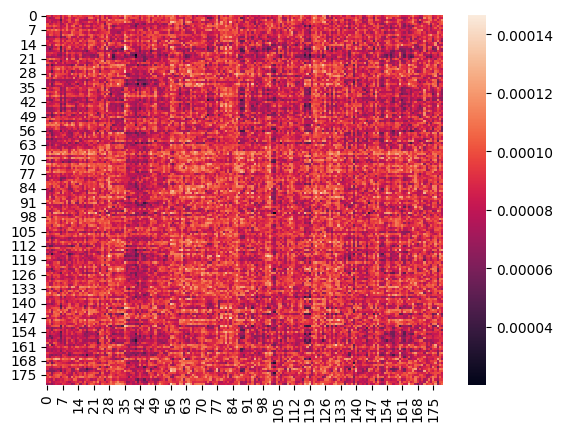

In [52]:
sns.heatmap(high_contribution[0])

<Axes: >

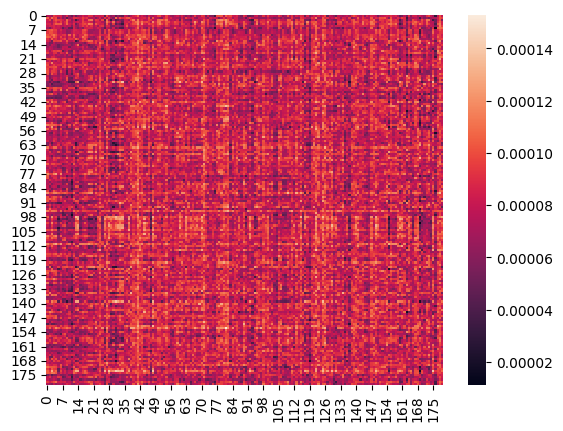

In [53]:
sns.heatmap(high_contribution_ADHD[0])

# 03 t-test between ADHD and HC

## 3-1 High frequency

In [35]:
p_values_high = np.zeros((180, 180))
t_stats_high = np.zeros((180, 180))
cohens_d_high = np.zeros((180, 180))
for i in range(180):
    for j in range(180):
        _, p_levene = levene(high_contribution[:, i, j], high_contribution_ADHD[:, i, j])
        equal_var = True if p_levene > 0.05 else False
        t_stat, p_value = ttest_ind(high_contribution[:, i, j], high_contribution_ADHD[:, i, j], equal_var=equal_var)
        cohens_d = (np.mean(high_contribution[:, i, j]) - np.mean(high_contribution_ADHD[:, i, j])) / np.sqrt(((len(high_contribution[:, i, j]) - 1) * np.var(high_contribution[:, i, j]) + (len(high_contribution_ADHD[:, i, j]) - 1) * np.var(high_contribution_ADHD[:, i, j])) / (len(high_contribution[:, i, j]) + len(high_contribution_ADHD[:, i, j]) - 2))
        p_values_high[i, j] = p_value
        t_stats_high[i, j] = t_stat
        cohens_d_high[i, j] = np.abs(cohens_d)
        
# FDR correction
p_values_flat = p_values_high.flatten()
_, p_values_corrected_flat = fdrcorrection(p_values_flat, alpha=0.05)
p_values_high_corrected = p_values_corrected_flat.reshape(180, 180)

<Axes: >

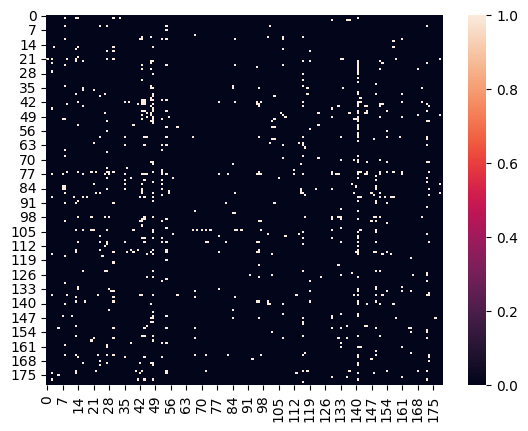

In [38]:
# statistically significant connectivity which are responsible for distinguishing two groups
filtered_matrix_high = np.where(p_values_high_corrected <= 0.05, 1, 0)
sns.heatmap(filtered_matrix_high)

<Axes: >

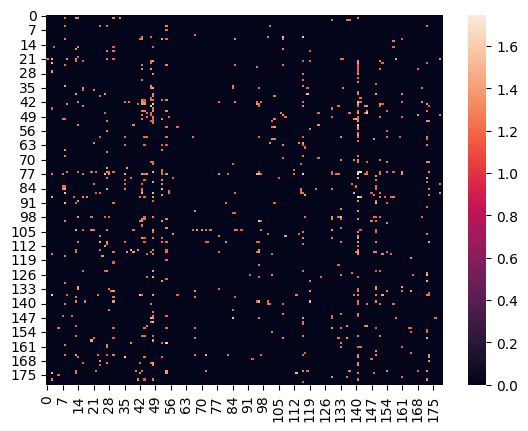

In [39]:
sns.heatmap(cohens_d_high*filtered_matrix_high)

<Axes: >

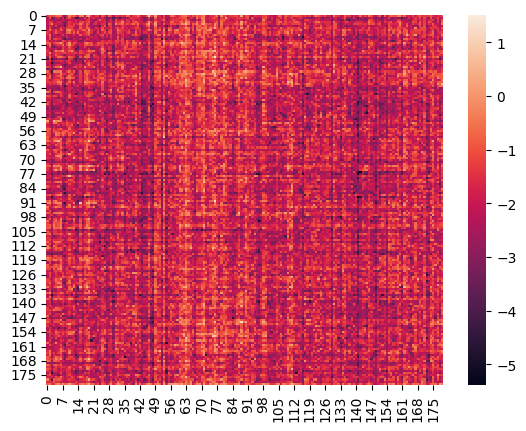

In [40]:
sns.heatmap(t_stats_high)

<Axes: >

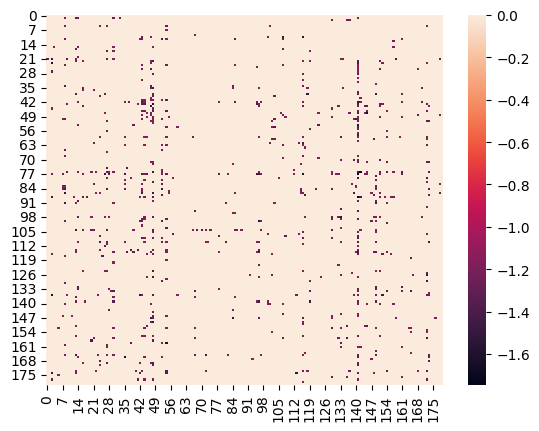

In [41]:
t_sign_high = np.where(t_stats_high < 0, -1, 1) # reversed
sns.heatmap(cohens_d_high*filtered_matrix_high*t_sign_high)

# 04 Load atlas meta data

In [43]:
# all hemispheres
atlas_info = pd.read_csv('../data/coordinates/HCP-MMP1_UniqueRegionList.csv', encoding='unicode_escape')

In [44]:
atlas_info = atlas_info.replace(r'\n', ' ', regex=True)

In [45]:
atlas_info

,regionName,regionLongName,regionIdLabel,LR,region,Lobe,cortex,regionID,Cortex_ID,x-cog,y-cog,z-cog,volmm
0,V1_L,Primary_Visual_Cortex_L,1_L,L,V1,Occ,Primary_Visual,1,1,100.491589,41.138901,71.637040,6717
1,MST_L,Medial_Superior_Temporal_Area_L,2_L,L,MST,Occ,MT+_Complex_and_Neighboring_Visual_Areas,2,5,132.416667,58.901786,82.059524,336
2,V6_L,Sixth_Visual_Area_L,3_L,L,V6,Occ,Dorsal_Stream_Visual,3,3,104.543112,44.481665,103.916749,1009
3,V2_L,Second_Visual_Area_L,4_L,L,V2,Occ,Early_Visual,4,2,102.236656,44.064791,74.401125,6220
4,V3_L,Third_Visual_Area_L,5_L,L,V3,Occ,Early_Visual,5,2,107.926111,40.632159,76.961153,4994
...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,STSva_R,Area_STSv_anterior_R,376_R,R,STSva,Temp,Auditory_Association,376,11,32.924419,117.527907,54.337791,1720
356,TE1m_R,Area_TE1_Middle_R,377_R,R,TE1m,Temp,Lateral_Temporal,377,14,26.146605,102.236497,53.246528,2592
357,PI_R,Para-Insular_Area_R,378_R,R,PI,Temp,Insular_and_Frontal_Opercular,378,12,47.013363,123.157016,57.926503,898
358,a32pr_R,Area_anterior_32_prime_R,379_R,R,a32pr,Fr,Anterior_Cingulate_and_Medial_Prefrontal,379,19,81.723096,153.990326,102.516324,827


# 05 Visualization on a glass brain

## 5-1 High frequency

In [46]:
significant_elements = cohens_d_high*filtered_matrix_high
flattened_indices = np.argsort(-significant_elements, axis=None)[:100]

filtered_matrix_high_mask = np.zeros_like(filtered_matrix_high)

rows, cols = np.unravel_index(flattened_indices, filtered_matrix_high.shape)

for row, col in zip(rows, cols):
    if t_sign_high[row, col]==abs(t_sign_high[row, col]):
        filtered_matrix_high_mask[row, col] = 1  
    else:
        filtered_matrix_high_mask[row, col] = -1

<Axes: >

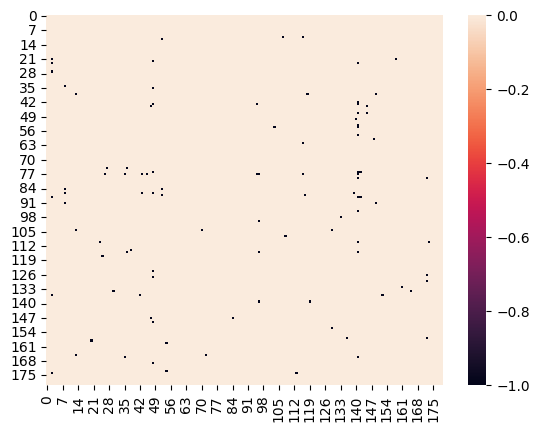

In [47]:
sns.heatmap(filtered_matrix_high_mask)

In [48]:
# symmetric

for i, j in zip(rows, cols):
    p_value = p_values_high[i, j]
    cohen = cohens_d_high[i, j]
    row = atlas_info[atlas_info['regionID'] == i+1][['regionLongName']].values[0][0]
    col = atlas_info[atlas_info['regionID'] == j+1][['regionLongName']].values[0][0]
    if filtered_matrix_high_mask[i, j] > 0:
        description = 'HC'
    elif filtered_matrix_high_mask[i, j] < 0:
        description = 'ADHD'
    else:
        description = 'None'
    print(row.replace('_', ' ')[:-2]+','+col.replace('_', ' ')[:-2]+','+description+','+str(round(p_value, 3))+','+str(round(cohen, 3)))

Rostral Area 6,Dorsal Transitional Visual Area,ADHD,0.0,1.745
Area anterior 10p,Dorsal Transitional Visual Area,ADHD,0.0,1.71
Area anterior 47r,Area PGp,ADHD,0.0,1.707
Area Posterior Insular 1,Area 5m,ADHD,0.0,1.636
Area Lateral IntraParietal ventral,Area IntraParietal 0,ADHD,0.0,1.631
Rostral Area 6,Anterior IntraParietal Area,ADHD,0.0,1.627
Area 6m anterior,Ventral IntraParietal Complex,ADHD,0.0,1.627
VentroMedial Visual Area 2,Area 6mp,ADHD,0.0,1.611
Area PHT,Sixth Visual Area,ADHD,0.0,1.605
Area OP1-SII,Inferior 6-8 Transitional Area,ADHD,0.0,1.6
Premotor Eye Field,Anterior IntraParietal Area,ADHD,0.0,1.582
Dorsal area 6,Dorsal Transitional Visual Area,ADHD,0.0,1.566
Primary Auditory Cortex,Sixth Visual Area,ADHD,0.0,1.565
Supplementary and Cingulate Eye Field,Dorsal Transitional Visual Area,ADHD,0.0,1.556
Area PF Complex,Area anterior 9-46v,ADHD,0.0,1.553
Area PHT,Supplementary and Cingulate Eye Field,ADHD,0.0,1.529
Area PGi,Ventral IntraParietal Complex,ADHD,0.0,1.524
Medial Area

<Axes: >

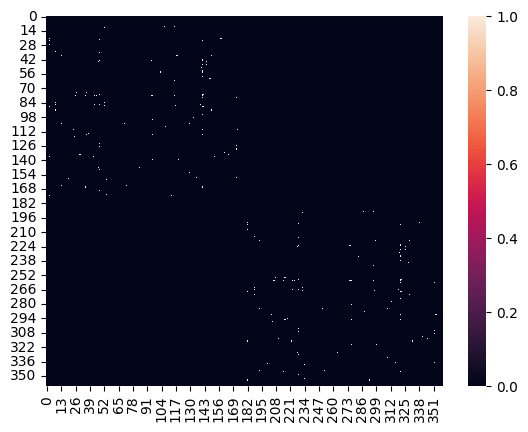

In [49]:
answer = np.zeros((360, 360))
answer[:180, :180] = filtered_matrix_high_mask
answer[180:, 180:] = filtered_matrix_high_mask
sns.heatmap(answer*(-1))

In [50]:
view = plotting.view_connectome(answer*(-1),coordinates, node_size=3.0)
view.save_as_html('sample_symmetric_ADHD_ROI_180_high_freq_sign.html')